In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath(os.path.abspath("")))
scriptsdir = os.path.dirname(currentdir)
if scriptsdir not in sys.path:
    sys.path.append(scriptsdir)

from customscripts import configuration
from customscripts import utils

# Common imports

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
human_formatter = ticker.FuncFormatter(utils.human_format)
%reload_ext autoreload
%autoreload 2

In [2]:
import re
data_food = utils.get_dataset_df(3, "all_categories") \
    .drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1", "Unnamed: 0.1.1.1", "Trade Flow Code", "Commodity", "Reporter", "Reporter Code", "Partner", "Partner Code", 'Development Category',
       'Development Level', 'Population in 2005 (in million)',
       'Population in 2010 (in million)', 'Population in 2014 (in million)',
       'Population in 2018 (in million)',
       '% Malnutritioned Childern < 5 years old', 'Total Imports in $',
       'Income Index Rank', 'ii2005', 'ii2006', 'ii2007', 'ii2008', 'ii2009',
       'ii2010', 'ii2011', 'ii2012', 'ii2013', 'ii2014', 'ii2015', 'ii2016',
       'ii2017', 'ii2018', "Qty", "Netweight (kg)", "Qty Unit Code", "Qty Unit", "Classification"]).reset_index(drop=True)
data_food["Year"] = pd.to_datetime(data_food["Year"], format="%Y")
# We just drop anything from 2006 and below, as the data is only present for IND for some reason
data_food["Commodity Code"] = data_food["Commodity Code"].astype(str)
data_food = data_food.loc[data_food["Year"] >= pd.datetime(2007, 1, 1)]

commodities_food = utils.get_dataset_df(3, "category_description")

data_countries = data_food["Reporter ISO"].unique()

data_unicef = utils.get_dataset_df(4, "nutrition_unicef_cleaned").drop(columns=["Unnamed: 0"])
data_unicef = utils.abbreviate_countries(data_unicef, "Country")
data_unicef = data_unicef[data_unicef["Country"].isin(data_countries)].reset_index(drop=True)
data_unicef = data_unicef.rename(columns={"TIME_PERIOD": "Year", "OBS_VALUE": "Value"})
data_unicef["Year"] = data_unicef["Year"].astype(str)
data_unicef = data_unicef[~data_unicef["Year"].isin(['1998-01', '1998-11', '2014-11', '2015-01', '2015-11', '2018-06', '2018-10'])]
data_unicef["Year"] = pd.to_datetime(data_unicef["Year"], format="%Y")
data_unicef = data_unicef[data_unicef["Current age"] == "Total"]

data_misc = utils.get_dataset_df(4, "final").drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Classification", "Trade Flow Code", "Reporter Code", "Partner Code", "Reporter", "Partner"]).reset_index(drop=True)
data_misc = data_misc.dropna(subset=["Commodity Code"])
data_misc["Commodity Code"] = data_misc["Commodity Code"].astype(str)
data_misc = data_misc.replace({"Commodity Code": { "(\d+)\.0" : r"\1" }}, regex=True)
data_misc["Year"] = pd.to_datetime(data_misc["Year"], format="%Y")

commodities_misc = data_misc[["Commodity Code", "Commodity", "Category Code", "Category"]].drop_duplicates().dropna().reset_index(drop=True)

data_gdp = utils.get_dataset_df(4, "GDP_per_capita").drop(columns=["Series Code", "Series Name", "Country Name"]) \
    .melt(id_vars=["Country Code"], var_name="Year", value_name="GDP") \
    .rename(columns={"Country Code": "Country"})
data_gdp = data_gdp[data_gdp["GDP"] != ".."]
data_gdp["Year"] = pd.to_datetime(data_gdp["Year"], format="%Y")
data_gdp["GDP"] = data_gdp["GDP"].astype(float)

data_population = utils.get_dataset_df(4, "population").drop(columns=["Indicator Code", "Indicator Name", "Country Name", "Unnamed: 65", "2020"]) \
    .rename(columns={"Country Code": "Country"}) \
    .melt(id_vars=["Country"], var_name="Year", value_name="Population")

data_misc = data_misc.drop(columns=["GDP Growth % in 2007", "GDP Growth % in 2008", "GDP Growth % in 2009", "GDP Growth % in 2010", "GDP Growth % in 2011", "GDP Growth % in 2012", "GDP Growth % in 2013", "GDP Growth % in 2014", "GDP Growth % in 2015", "GDP Growth % in 2016", "GDP Growth % in 2017", "GDP Growth % in 2018", "GDP Growth % in 2019", 'Population in 2005 (in million)', 'Population in 2010 (in million)',
       'Population in 2014 (in million)', 'Population in 2018 (in million)', "Development Category", "Development Level", "Commodity"])

data_all = pd.concat([data_food, data_misc], ignore_index=True).sort_values(by="Year", ignore_index=True)

commodities_codes = pd.concat([commodities_food[["Commodity Code", "Commodity", "Category", "Category Code"]], commodities_misc], ignore_index=True)
commodities_codes["Commodity Code"] = commodities_codes["Commodity Code"].astype(str)
commodities_codes["Category Code"] = commodities_codes["Category Code"].astype(str)

In [3]:
commodities_codes[commodities_codes["Category Code"] == "7"].iloc[0]["Category"]

'Base Metals'

In [4]:
import help_functions as HF

# GDP Change per year

Let's start by exploring some additional

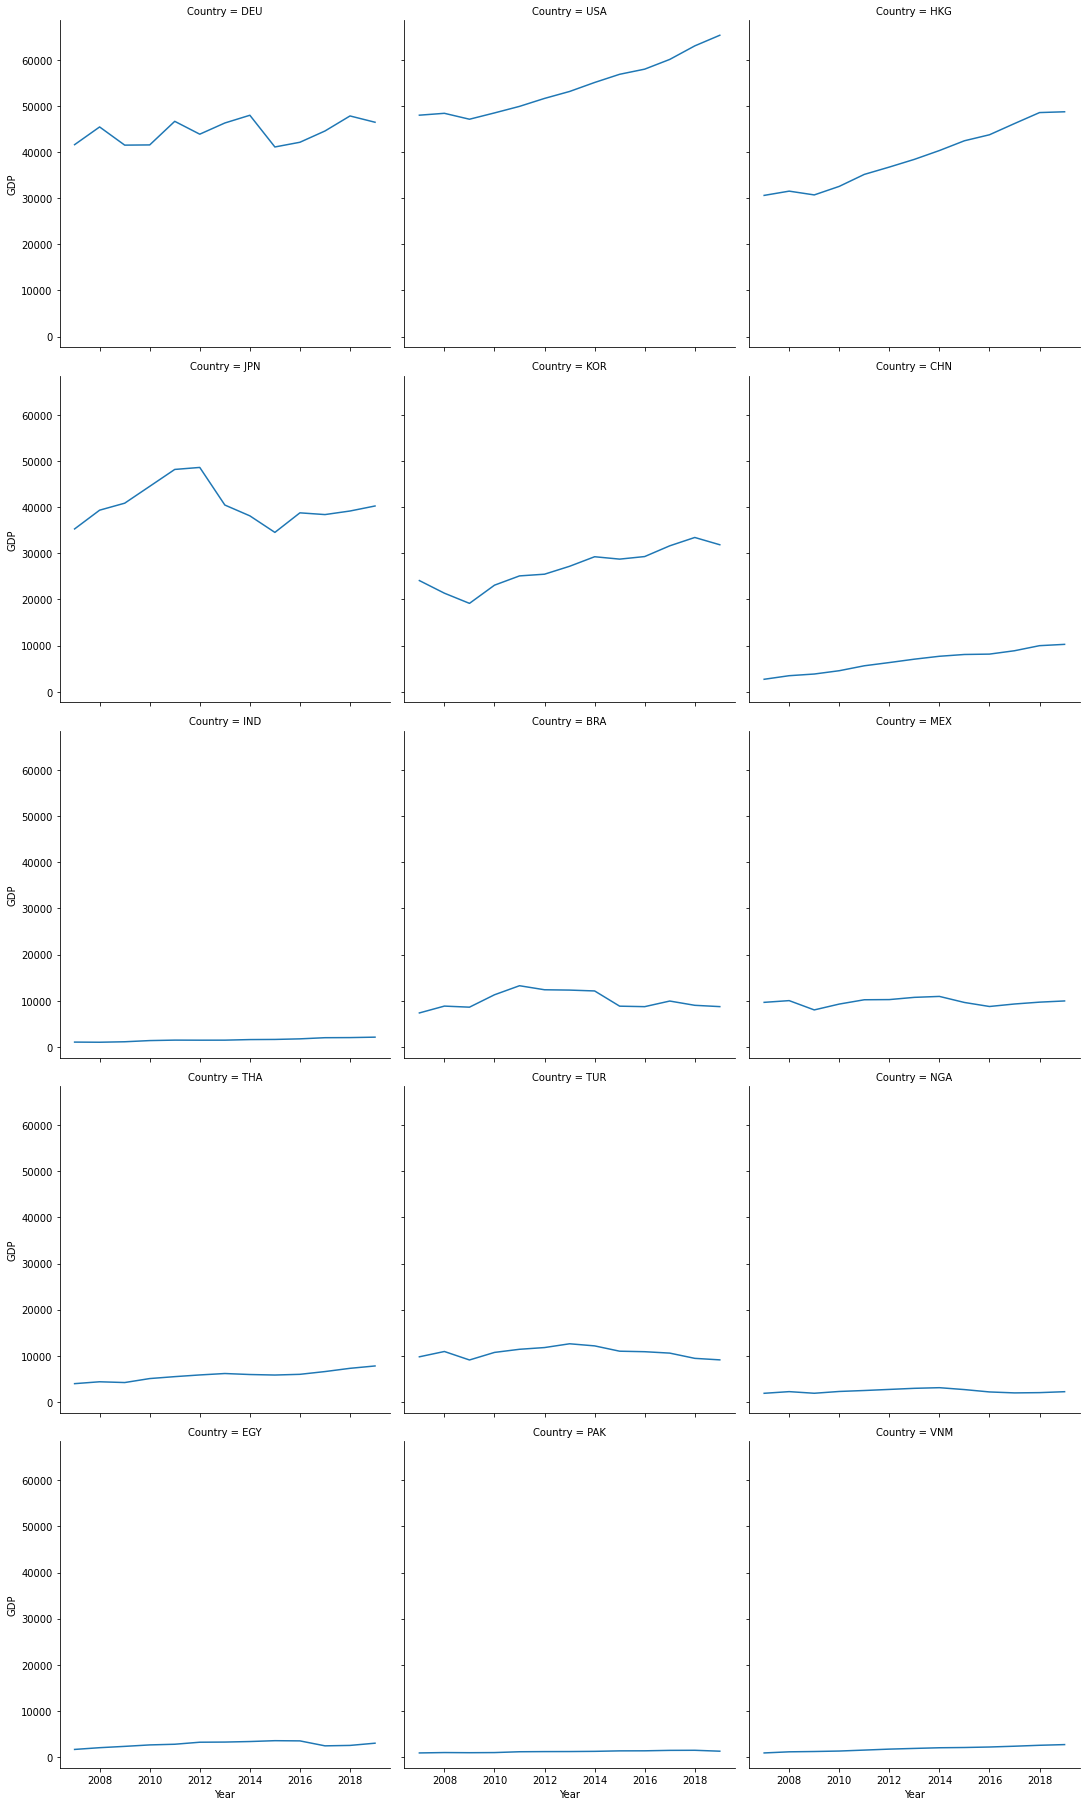

In [5]:
sns.relplot(data=data_gdp, x="Year", y="GDP", col="Country", kind="line", col_wrap=3);

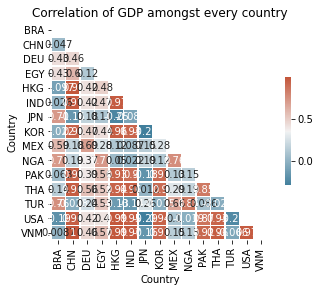

In [6]:
data_gdp_wide = data_gdp.pivot_table(index="Year", columns="Country", values="GDP")
HF.plot_gdp_countries_corr(data_gdp_wide, title="Correlation of GDP amongst every country")

In [7]:
data_gdp_wide = data_gdp.pivot_table(index="Year", columns="Country", values="GDP")

print("Worst 10 Absolute Correlations")
print(HF.get_top_correlations(data_gdp_wide, 5, True))
print("Top 10 Absolute Correlations")
print(HF.get_top_correlations(data_gdp_wide, 5, False))

Worst 10 Absolute Correlations
Country  Country
BRA      VNM        0.008670
JPN      THA        0.012119
KOR      TUR        0.014588
NGA      USA        0.019181
IND      NGA        0.021517
dtype: float64
Top 10 Absolute Correlations
Country  Country
CHN      VNM        0.997318
HKG      USA        0.988061
         VNM        0.986794
CHN      HKG        0.983648
HKG      IND        0.969409
dtype: float64


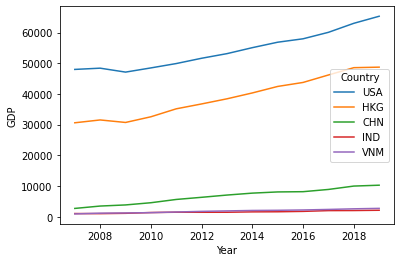

In [8]:
sns.lineplot(data=data_gdp[data_gdp["Country"].isin(["CHN", "VNM", "HKG", "USA", "IND"])], x="Year", y="GDP", hue="Country");

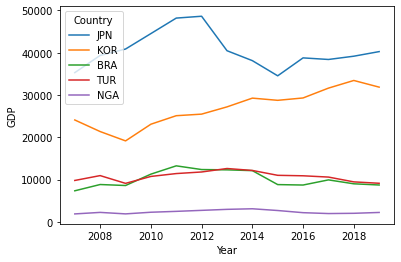

In [9]:
sns.lineplot(data=data_gdp[data_gdp["Country"].isin(["BRA", "JPN", "KOR", "TUR", "NGA"])], x="Year", y="GDP", hue="Country");


# Trade Balance

In [10]:
data_gdp

,Country,Year,GDP
0,DEU,2007-01-01,41587.212900
1,USA,2007-01-01,47975.967700
2,HKG,2007-01-01,30594.017840
3,JPN,2007-01-01,35275.228430
4,KOR,2007-01-01,24086.410440
...,...,...,...
190,TUR,2019-01-01,9126.561346
191,NGA,2019-01-01,2229.858696
192,EGY,2019-01-01,3019.205829
193,PAK,2019-01-01,1284.702041


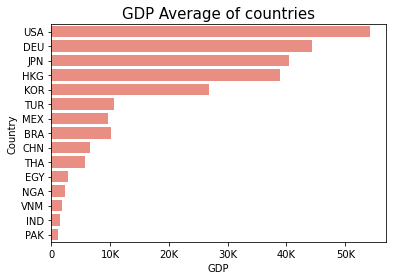

In [11]:
HF.plot_average_gdp(data_gdp)

# GDP Categorization

Following the above graph, we cathegorize the countries according to their GDP.

High GDP Countries:
- USA
- DEU
- JPN
- HKG
- KOR

Median GDP Countries:
- TUR
- MEX
- BRA
- CHN
- THA

Low GDP Countries:
- EGY
- NGA
- VNM
- IND
- PAK


In [12]:
high_gdp = ["USA", "DEU", "JPN", "HKG", "KOR"]
medium_gdp = ["TUR", "MEX", "BRA", "CHN", "THA", ]
low_gdp = ["EGY", "NGA", "VNM", "IND", "PAK"]
gdp_level = [high_gdp, medium_gdp, low_gdp]
category_label = ["high", "medium", "low"]


In [13]:
def tmp(x):
    for index, level in enumerate(category_label):
        if x in gdp_level[index]:
            return level
data_misc["GDP Level"] = data_misc["Reporter ISO"].apply(tmp)
data_gdp["GDP Level"] = data_gdp["Country"].apply(tmp)

In [14]:
data_misc_no_tha_guns = data_misc.loc[~((data_misc["Reporter ISO"] == "THA") & (data_misc["Category Code"] == 9)), :]
data_misc_no_low_guns = data_misc_no_tha_guns.loc[~((data_misc_no_tha_guns["Reporter ISO"].isin(["EGY", "NGA", "VNM"])) & (data_misc_no_tha_guns["Category Code"] == 9)), :]

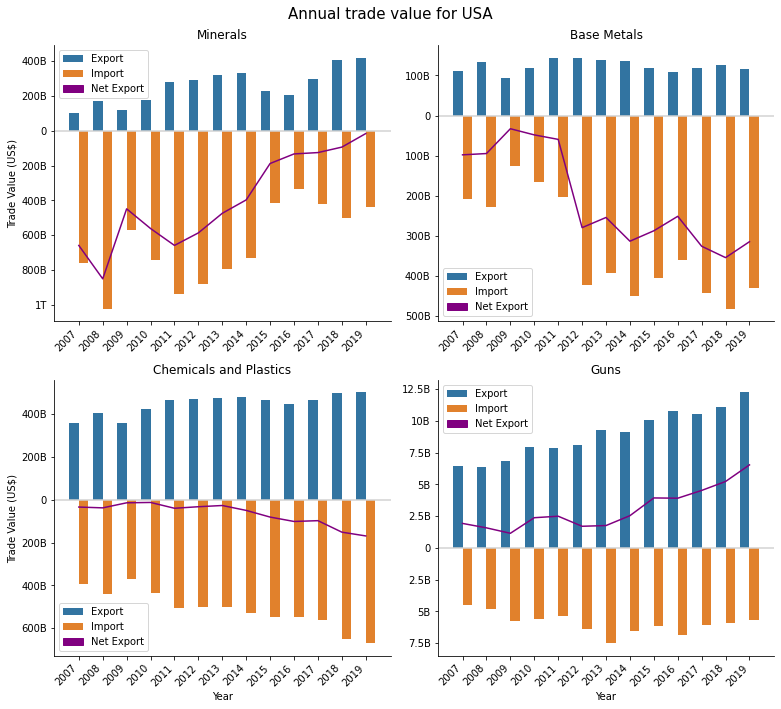

In [15]:
HF.plot_trade_balance_country(data_misc_no_low_guns.groupby(["Year", "Trade Flow", "GDP Level", "Reporter ISO", "Category Code"])["Trade Value (US$)"].sum().reset_index(), commodities_codes, "USA")

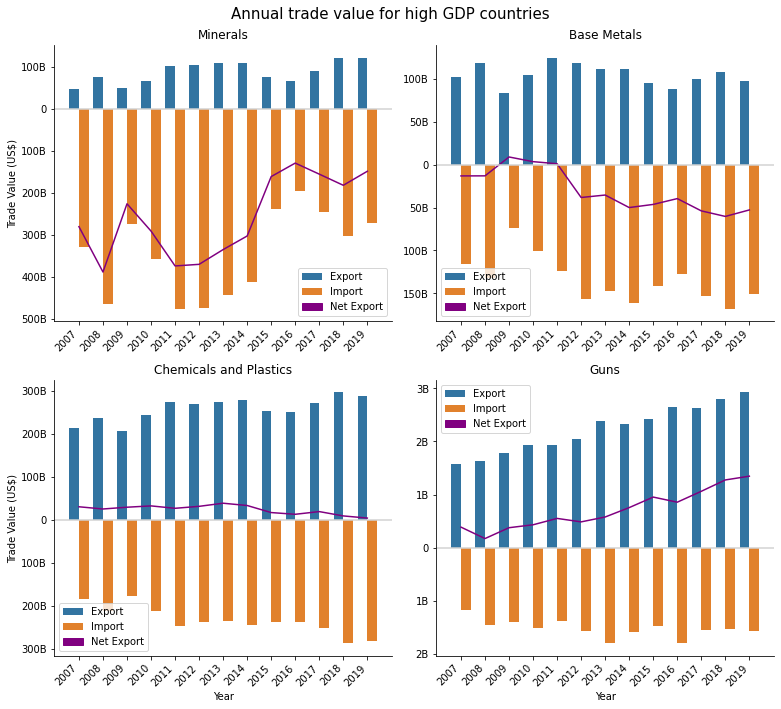

In [16]:
HF.plot_trade_balance_country_level(data_misc_no_low_guns.groupby(["Year", "Trade Flow", "GDP Level", "Reporter ISO", "Category Code"])["Trade Value (US$)"].sum().reset_index(), commodities_codes, "high")

In [17]:
# data_misc[(data_misc["Reporter ISO"] == "THA") & (data_misc["Category Code"] == 8)]
# data_misc.loc[~((data_misc["Reporter ISO"] == "THA") & (data_misc["Category Code"] == 8)), :]

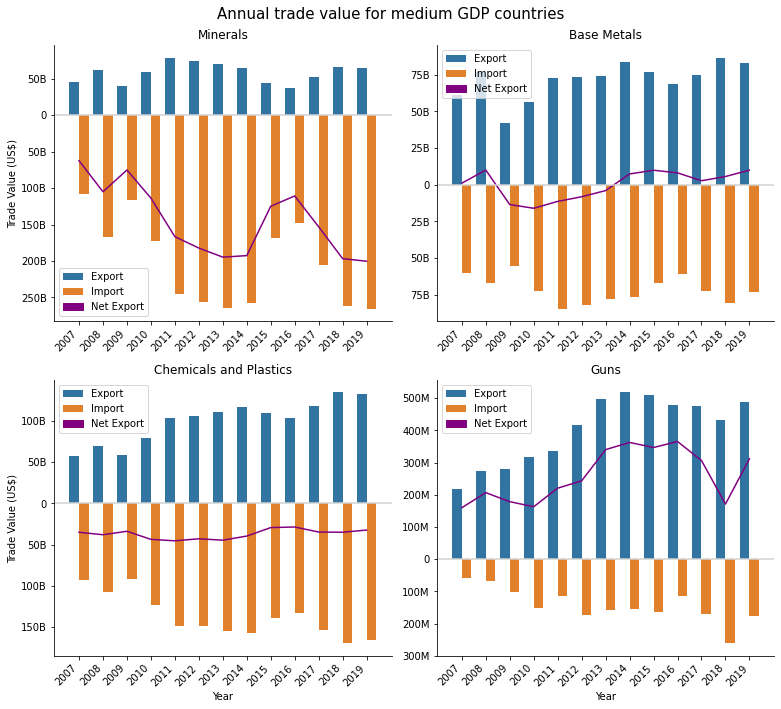

In [18]:
HF.plot_trade_balance_country_level(data_misc_no_low_guns.groupby(["Year", "Trade Flow", "GDP Level", "Reporter ISO", "Category Code"])["Trade Value (US$)"].sum().reset_index(), commodities_codes, "medium")

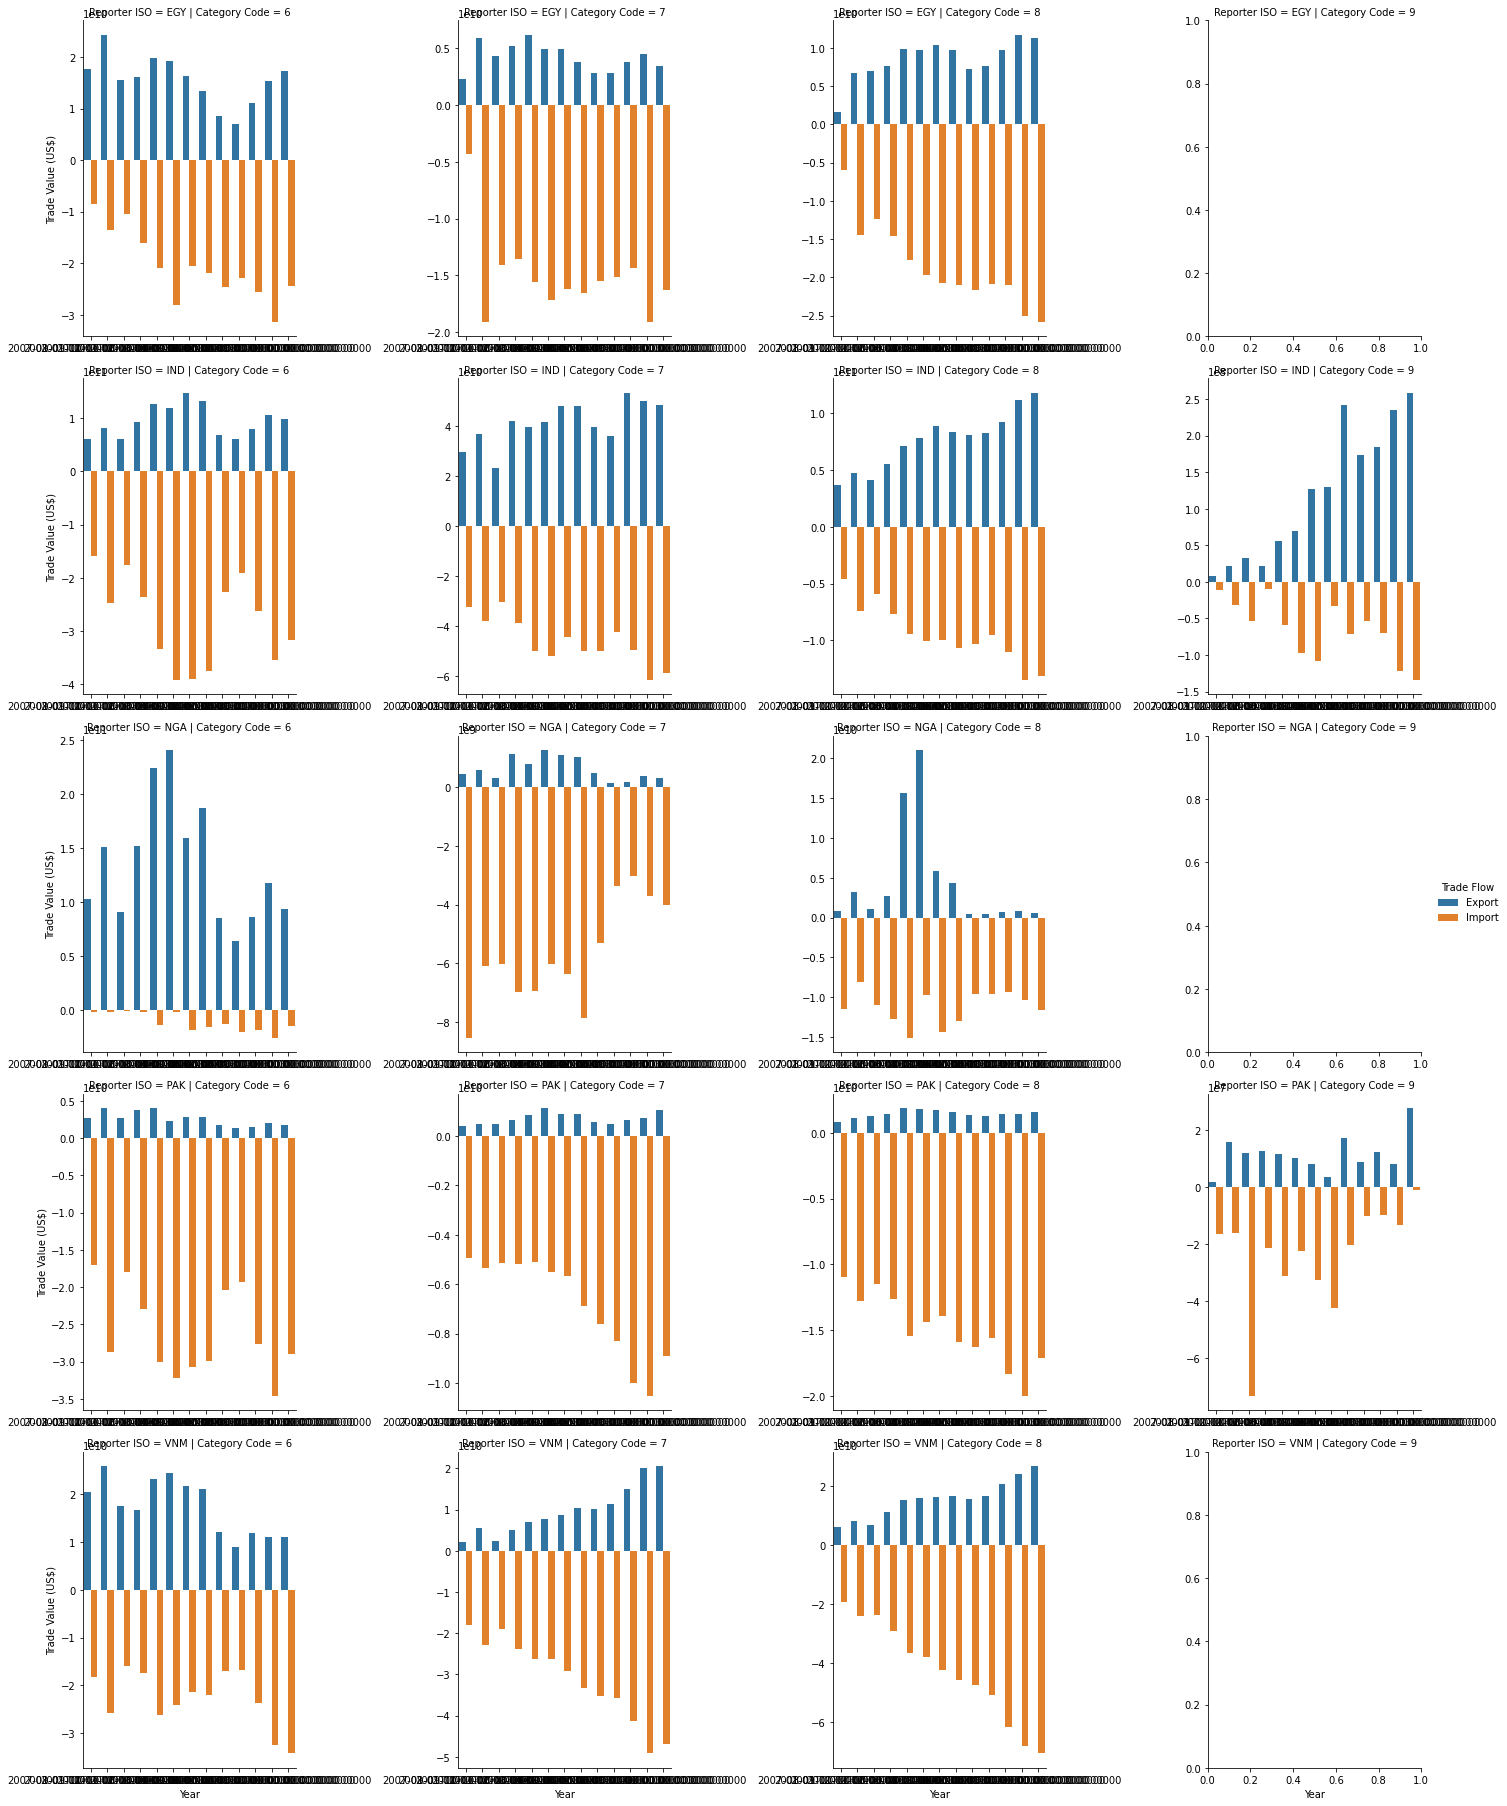

In [19]:
tmp_data = HF.negative_imports_data(data_misc_no_low_guns[data_misc_no_low_guns["GDP Level"] == "low"].groupby(["Year", "Trade Flow", "Reporter ISO", "Category Code"])["Trade Value (US$)"].sum().reset_index())

g = sns.catplot(
    kind="bar",
    data=tmp_data,
    x="Year",
    y="Trade Value (US$)",
    hue="Trade Flow",
    row="Reporter ISO",
    col="Category Code",
    sharex=False,
    sharey=False,
    ci=None  # No error bars
)

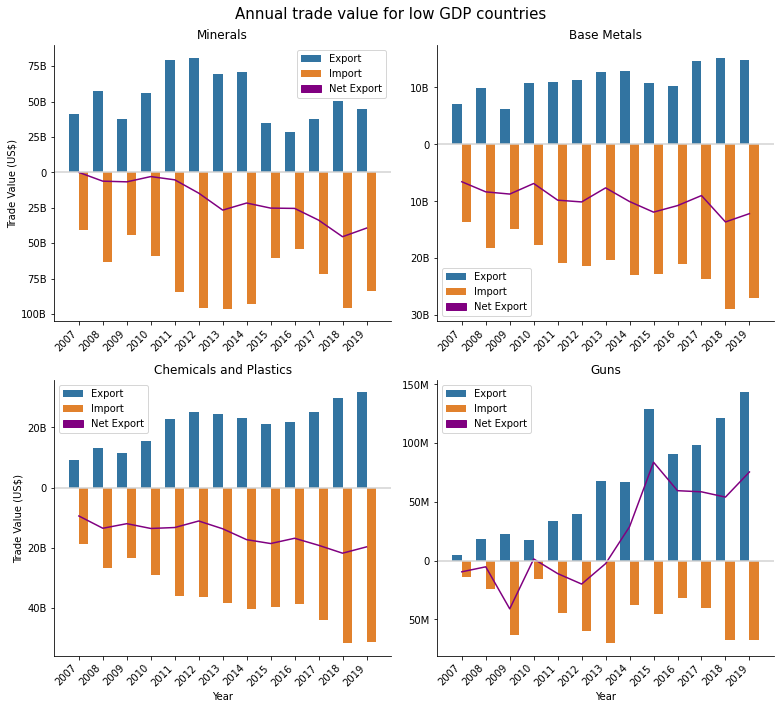

In [20]:
HF.plot_trade_balance_country_level(data_misc_no_low_guns.groupby(["Year", "Trade Flow", "GDP Level", "Reporter ISO", "Category Code"])["Trade Value (US$)"].sum().reset_index(), commodities_codes, "low")

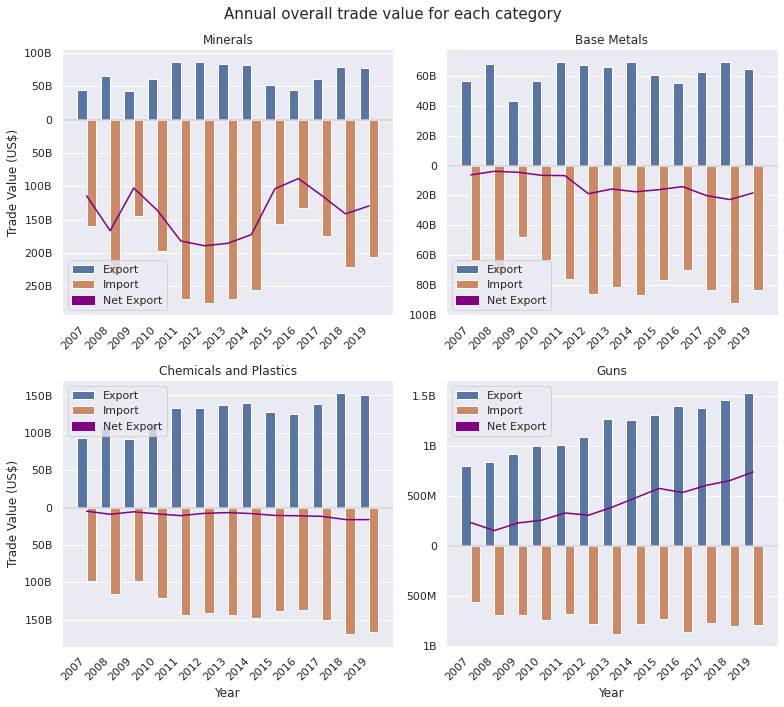

In [29]:
HF.plot_trade_balance_all_countries(data_misc_no_low_guns.groupby(["Year", "Trade Flow", "GDP Level", "Reporter ISO", "Category Code"])["Trade Value (US$)"].sum().reset_index(), commodities_codes)

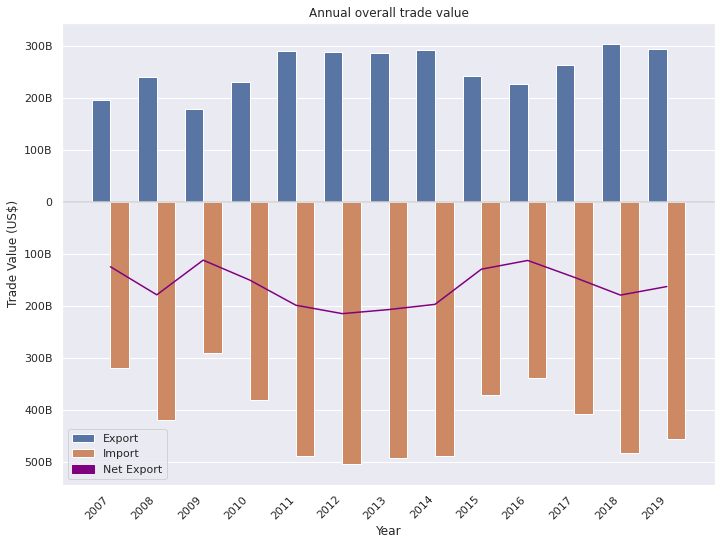

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
HF.plot_trade_balance_all_categories(data_misc_no_low_guns.groupby(["Year", "Trade Flow", "GDP Level", "Reporter ISO"])["Trade Value (US$)"].sum().reset_index(), commodities_codes)

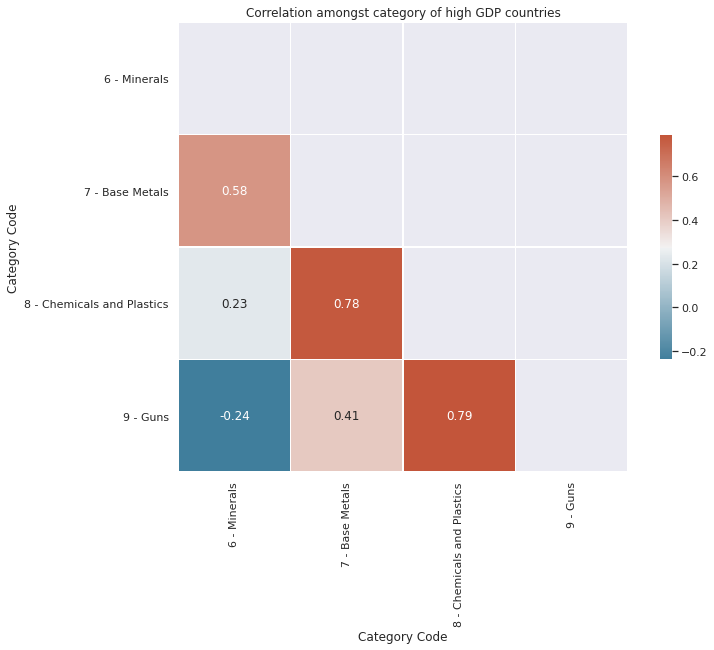

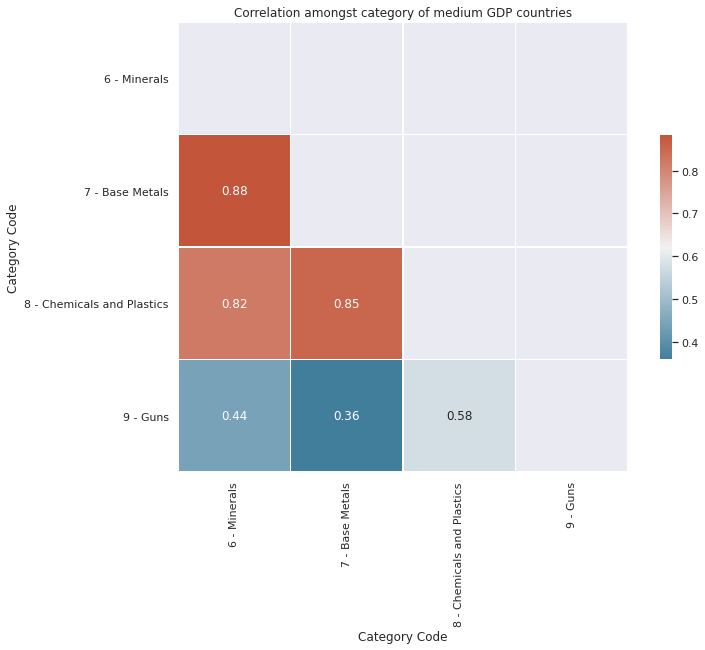

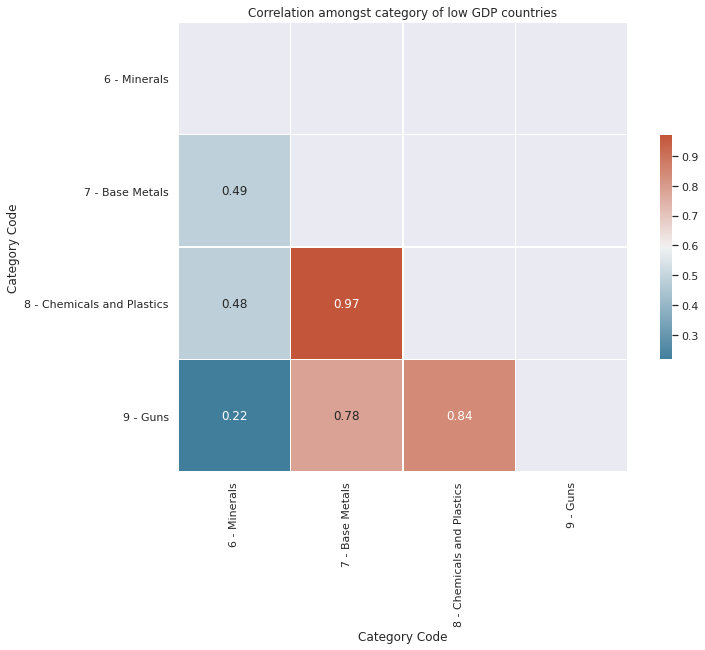

In [23]:
HF.plot_corr_countries_level(data_misc, commodities_codes, "high")
HF.plot_corr_countries_level(data_misc, commodities_codes, "medium")
HF.plot_corr_countries_level(data_misc, commodities_codes, "low")

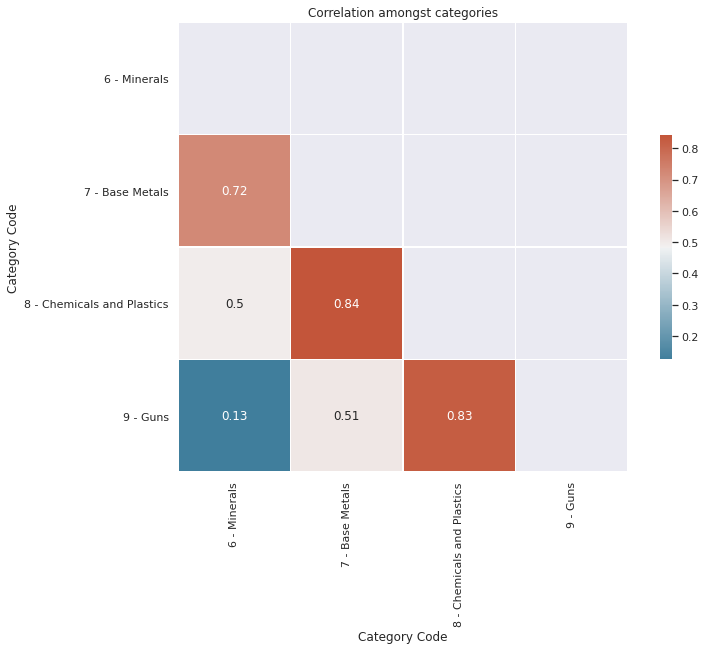

In [24]:
HF.plot_corr_product_category(data_misc, commodities_codes)

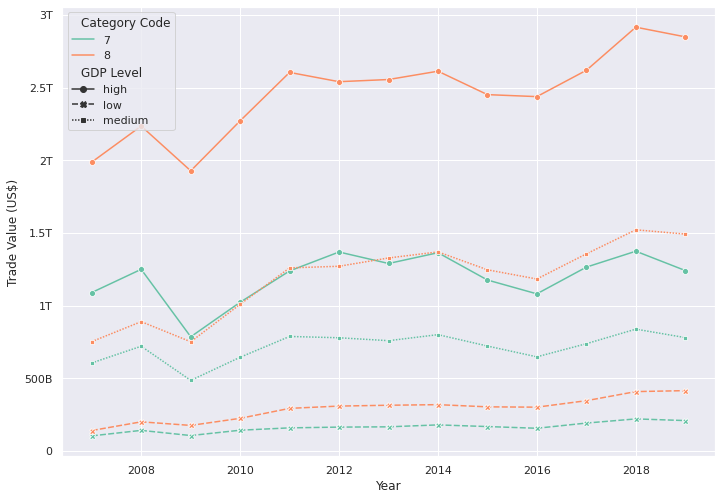

In [25]:
g = sns.lineplot(data=data_misc[data_misc["Category Code"].isin([7, 8])].groupby(["Year", "GDP Level", "Category Code"])["Trade Value (US$)"].sum().reset_index().sort_values(by=["GDP Level"]), x="Year", y="Trade Value (US$)", style="GDP Level", hue="Category Code", palette="Set2", markers=True);
HF.adjust_human_axis(g)
plt.show();


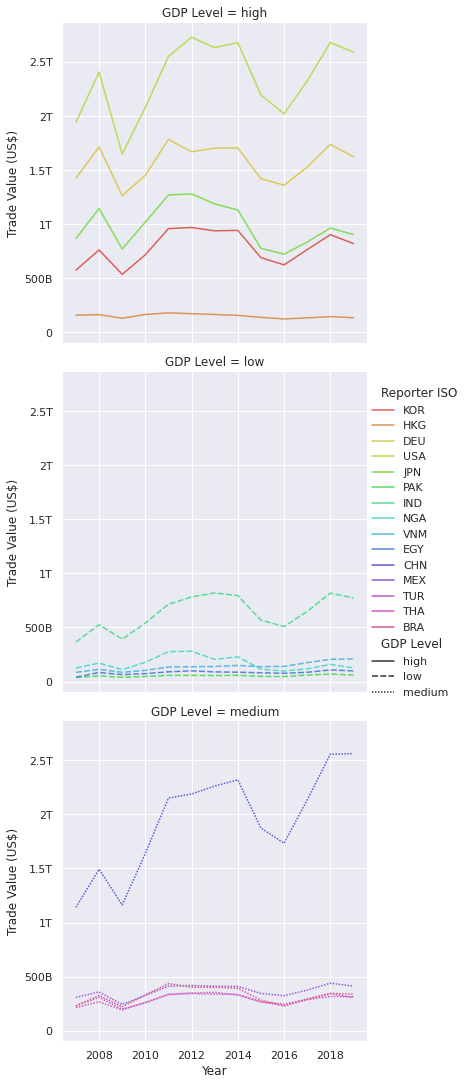

In [26]:
g = sns.relplot(data=data_misc.groupby(["Year", "Reporter ISO", "GDP Level"])["Trade Value (US$)"].sum().reset_index().sort_values(by=["GDP Level"]), x="Year", y="Trade Value (US$)", hue="Reporter ISO", row="GDP Level", style="GDP Level", kind="line", palette="hls", legend="brief");
for _, ax in g.axes_dict.items():
    HF.adjust_human_axis(ax)
plt.show();
